# 📊 Pipeline de Limpeza e Análise de Engajamento de Alunos

Este notebook consolida todas as etapas de processamento de dados de engajamento estudantil:

1. Carregamento e reestruturação dos dados brutos
2. Limpeza e padronização de valores
3. Cálculo de scores de engajamento
4. Clustering e análise de perfis


## PARTE 1: Carregamento e Preparação dos Dados Brutos


In [7]:
import pandas as pd
import numpy as np
import re

# Carregamento do arquivo principal
file = 'Base anonimizada - Eric - PUC-SP.xlsx'
data = pd.read_excel(file, skiprows=2)

# Extrair datas das aulas
dates = pd.read_excel(file)
dates = (
    dates.drop(columns=[col for col in dates.columns if 'Unnamed:' in col])
    .iloc[0]
    .to_dict()
)

In [8]:
# Definir colunas por aula e funções auxiliares
colunas_por_aula = ['Pre-Class', 'P', 'Hw', 'CP', 'Bh']
id_columns = ['Nome Planilha Feedback', 'Sala', 'Num', 'NOME COMPLETO']

def is_class_column(col: str) -> bool:
    """Verifica se a coluna faz parte do grupo de notas por aula."""
    return col.split('.')[0] in colunas_por_aula

def split_colum_values(col: str):
    """Divide a coluna entre o nome base e o número da aula."""
    try:
        coluna, aula = col.split('.')
        return is_class_column(coluna), coluna, int(aula)
    except:
        return is_class_column(col), col, 0

def get_class_date(aula_idx: int):
    """Obtém a data da aula a partir do dicionário de datas."""
    aula_key = f'Aula {aula_idx + 1}' if aula_idx > 0 else 'Aula 1'
    return dates.get(aula_key, None)

def extrair_unidade(texto):
    """Extrai o nome da unidade do campo 'Nome Planilha Feedback'."""
    partes = str(texto).split(' - ')
    return partes[2] if len(partes) > 2 else None

In [9]:
# Reorganizar dados por aula
class_columns = [col for col in data.columns if is_class_column(col)]
all_classes = []

for col in class_columns:
    needed, col_name, aula_idx = split_colum_values(col)
    if not needed:
        continue
    
    group_cols = [f'{c}.{aula_idx}' if f'{c}.{aula_idx}' in data.columns else c for c in colunas_por_aula]
    aula_df = data[id_columns + [c for c in group_cols if c in data.columns]].copy()
    aula_df['Aula'] = aula_idx + 1
    aula_df['Data'] = get_class_date(aula_idx)
    aula_df.rename(columns={c: c.split('.')[0] for c in group_cols if '.' in c}, inplace=True)
    all_classes.append(aula_df)

# Concatenar todos os dados de aulas
compiled = pd.concat(all_classes, ignore_index=True)

In [10]:
# Extrair informações de aluno e unidade
compiled['Aluno'] = compiled['NOME COMPLETO'].apply(lambda x: str(x).split(' - ')[0])
compiled['Unidade'] = compiled['Nome Planilha Feedback'].apply(extrair_unidade)

# Montar base final com as colunas relevantes
base_final = compiled[[
    'Aluno', 'Unidade', 'Sala', 'Aula', 'Data',
    'Pre-Class', 'P', 'Hw', 'CP', 'Bh'
]].drop_duplicates()

# Renomear colunas para nomes descritivos
base_final = base_final.rename(columns={
    'Pre-Class': 'Fez a atividade antes da aula',
    'P': 'Presença/Ausencia',
    'Hw': 'Fez lição de casa',
    'CP': 'Participação',
    'Bh': 'Comportamento'
})

# Ordenar dados
base_final.sort_values(by=['Unidade', 'Sala', 'Aluno', 'Aula'], inplace=True)

print("✓ Dados carregados e estruturados com sucesso")

✓ Dados carregados e estruturados com sucesso


In [11]:
# Converter datas em formato português para datetime
def parse_portuguese_dates(dates):
    if isinstance(dates, pd.Series):
        dates = dates.astype(str).replace(['nan', 'None'], np.nan)
    elif not isinstance(dates, list):
        raise TypeError("O argumento deve ser uma lista ou pd.Series.")
    
    meses = {
        'jan.': 'Jan', 'fev.': 'Feb', 'mar.': 'Mar', 'abr.': 'Apr',
        'mai.': 'May', 'jun.': 'Jun', 'jul.': 'Jul', 'ago.': 'Aug',
        'set.': 'Sep', 'out.': 'Oct', 'nov.': 'Nov', 'dez.': 'Dec'
    }

    datas_en = []
    for d in dates:
        if isinstance(d, str):
            for pt, en in meses.items():
                d = d.replace(pt, en)
        datas_en.append(d)

    return pd.to_datetime(datas_en, format='%d-%b-%Y', errors='coerce')

base_final['Data'] = parse_portuguese_dates(base_final.Data.to_list())

# Remover linhas com datas inválidas
base_final.dropna(subset=['Data'], inplace=True)

print("✓ Datas parseadas e limpas")

✓ Datas parseadas e limpas


## PARTE 2: Limpeza e Padronização de Valores


In [13]:
# Criar cópia para processamento
df = base_final.copy()

# Funções de mapeamento para limpeza de dados
def limpar_coluna_aula(x):
    """Corrige a coluna Aula, mantendo apenas números inteiros válidos."""
    if pd.isna(x):
        return np.nan
    
    if isinstance(x, (int, float)):
        return int(x)
    
    x = str(x).strip()
    
    if "/" in x:
        return np.nan
    
    num = re.sub(r"[^\d]", "", x)
    
    if num == "":
        return np.nan
    
    return int(num)

def mapear_binario(x):
    """Converte símbolos (√, N, +/-) para valores binários."""
    if pd.isna(x):
        return 0
    x = str(x).strip()
    if x == "√":
        return 1
    if x in ["N", "n", "0"]:
        return 0
    if x in ["+/-"]:
        return 0.5
    return 0

def mapear_presenca(x):
    """Mapeia P (presente), A/F (ausente) para valores binários."""
    if pd.isna(x):
        return np.nan
    
    x = str(x).strip().upper()
    
    if x == "P":
        return 1
    if x in ["A", "F"]:
        return 0
    
    return np.nan

def mapear_participacao(x):
    """Converte emojis de participação em escala numérica (0-3)."""
    if pd.isna(x):
        return 1  # neutro
    
    x = str(x).strip()
    
    mapa = {
        ":-D": 3,
        ":-)": 2,
        ":-|": 1,
        ":-/": 1,
        ":-&": 0,
        ":-(": 0,
    }
    
    return mapa.get(x, 1)

In [21]:
# Aplicar funções de limpeza
df["Aula"] = df["Aula"].apply(limpar_coluna_aula)
df["Data"] = pd.to_datetime(df["Data"], errors="coerce")
df["Fez a atividade antes da aula"] = df["Fez a atividade antes da aula"].apply(mapear_binario)
df["Fez lição de casa"] = df["Fez lição de casa"].apply(mapear_binario)
df["Presença/Ausencia"] = df["Presença/Ausencia"].apply(mapear_presenca)
df["Participação"] = df["Participação"].apply(mapear_participacao)

# Remover coluna Comportamento se existir
if "Comportamento" in df.columns:
    df = df.drop(columns=["Comportamento"])

# Tratar missing values
cols_numericas = ["Fez a atividade antes da aula", "Fez lição de casa", 
                  "Participação", "Presença/Ausencia"]
df[cols_numericas] = df[cols_numericas].fillna(0)

# Remover duplicatas
df = df.drop_duplicates()

# Remover linhas com erros
df = df[df["Fez a atividade antes da aula"] != '#ERROR!']
df = df.dropna(subset=["Fez a atividade antes da aula"], how='all')

print("✓ Dados limpos e padronizados")

✓ Dados limpos e padronizados


In [33]:
df['Aluno'] = df["Aluno"] + df["Sala"].astype(str) + df["Unidade"].astype(str)

In [34]:
# Salvar dados limpos intermediários
df.to_csv('eric-dados-compilados-LIMPO.csv', index=False)
print("✓ Arquivo salvo: eric-dados-compilados-LIMPO.csv")

✓ Arquivo salvo: eric-dados-compilados-LIMPO.csv


In [35]:
df_scores = df.copy()


In [36]:
df_scores

,Aluno,Unidade,Sala,Aula,Data,Fez a atividade antes da aula,Presença/Ausencia,Fez lição de casa,Participação,aluno
108,Estudante 1Four Corners A1Campinas,Campinas,Four Corners A1,1,2025-02-08,0,0.0,0,1,Estudante 1Four Corners A1Campinas
9993,Estudante 1Four Corners A1Campinas,Campinas,Four Corners A1,2,2025-02-15,0,0.0,0,1,Estudante 1Four Corners A1Campinas
19878,Estudante 1Four Corners A1Campinas,Campinas,Four Corners A1,3,2025-02-22,0,0.0,0,1,Estudante 1Four Corners A1Campinas
29763,Estudante 1Four Corners A1Campinas,Campinas,Four Corners A1,4,2025-03-08,0,0.0,0,1,Estudante 1Four Corners A1Campinas
39648,Estudante 1Four Corners A1Campinas,Campinas,Four Corners A1,5,2025-03-15,0,0.0,0,1,Estudante 1Four Corners A1Campinas
...,...,...,...,...,...,...,...,...,...,...
80254,Estudante 6Four Corners I1Vila Sônia (tarde),Vila Sônia (tarde),Four Corners I1,9,2025-04-26,0,0.0,0,1,Estudante 6Four Corners I1Vila Sônia (tarde)
90139,Estudante 6Four Corners I1Vila Sônia (tarde),Vila Sônia (tarde),Four Corners I1,10,2025-05-17,0,0.0,0,1,Estudante 6Four Corners I1Vila Sônia (tarde)
100024,Estudante 6Four Corners I1Vila Sônia (tarde),Vila Sônia (tarde),Four Corners I1,11,2025-05-24,0,0.0,0,1,Estudante 6Four Corners I1Vila Sônia (tarde)
109909,Estudante 6Four Corners I1Vila Sônia (tarde),Vila Sônia (tarde),Four Corners I1,12,2025-05-31,0,0.0,0,1,Estudante 6Four Corners I1Vila Sônia (tarde)


## PARTE 3: Cálculo de Scores de Engajamento


In [37]:
# Preparar dataset para cálculo de scores
df_scores = df.copy()

# Renomear colunas para nomenclatura interna mais simples
df_scores.rename(columns={
    "Fez a atividade antes da aula": "atividade_antes",
    "Presença/Ausencia": "presenca",
    "Fez lição de casa": "licao_casa",
    "Participação": "participacao"
}, inplace=True)

# Normalizar participação (escala 0-1)
df_scores["participacao_norm"] = df_scores["participacao"] / 3

# Criar scores individuais
df_scores["prep_score"] = df_scores["atividade_antes"]
df_scores["attendance_score"] = df_scores["presenca"]
df_scores["homework_score"] = df_scores["licao_casa"]
df_scores["interaction_score"] = df_scores["participacao_norm"]

# Calcular engajamento geral (ponderado)
df_scores["engajamento"] = (
    0.30 * df_scores["atividade_antes"] +
    0.45 * df_scores["presenca"] +
    0.20 * df_scores["licao_casa"] +
    0.15 * df_scores["participacao_norm"]
)

# Converter para percentual
df_scores["engajamento_pct"] = (df_scores["engajamento"] * 100).round(2)

# Função para recomendar ação baseada no perfil
def recomendar_acao(row):
    if row["attendance_score"] < 0.6:
        return "Contato individual / intervenção para frequência"
    
    if row["homework_score"] < 0.4 and row["prep_score"] < 0.4:
        return "Envio de reforço assíncrono e acompanhamento semanal"
    
    if row["interaction_score"] < 0.4:
        return "Atividades de engajamento em sala"
    
    if row["engajamento"] > 0.8:
        return "Elogio e reforço positivo"
    
    return "Acompanhamento normal"

df_scores["acao_recomendada"] = df_scores.apply(recomendar_acao, axis=1)

print("✓ Scores de engajamento calculados")

✓ Scores de engajamento calculados


In [38]:
# Salvar dataset com scores
df_scores.to_csv('eric-dados-engajamento.csv', index=False)

# Visualizar amostra dos dados finais
print("\n📊 Primeiras linhas do dataset com scores:")
print(df_scores[[
    'Aluno', 'Unidade', 'Sala', 'Aula', 'Data',
    'prep_score', 'attendance_score', 'homework_score', 'interaction_score',
    'engajamento', 'engajamento_pct', 'acao_recomendada'
]].head(10))


📊 Primeiras linhas do dataset com scores:
                                    Aluno   Unidade             Sala  Aula  \
108    Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     1   
9993   Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     2   
19878  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     3   
29763  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     4   
39648  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     5   
49533  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     6   
59418  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     7   
69303  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     8   
79188  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1     9   
89073  Estudante 1Four Corners A1Campinas  Campinas  Four Corners A1    10   

            Data  prep_score  attendance_score  homework_score  \
108   2025-02-08           0    

## PARTE 4: Análise de Clustering e Perfis de Alunos


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Criar agregação por aluno
aluno_stats = df_scores.groupby("Aluno")[[
    "prep_score",
    "attendance_score",
    "homework_score",
    "interaction_score",
    "engajamento"
]].mean()

# Padronizar features para clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(aluno_stats)

# Aplicar K-Means com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
aluno_stats["cluster"] = kmeans.fit_predict(X_scaled)

# Salvar resultado do clustering
aluno_stats.to_csv('clusters_alunos.csv')

# Criar perfil dos clusters
cluster_profile = aluno_stats.groupby("cluster")[
    ["prep_score", "attendance_score", "homework_score", "interaction_score", "engajamento"]
].mean()

cluster_profile.to_csv('perfil_clusters.csv')

print("✓ Clustering realizado")
print("\nDistribuição de alunos por cluster:")
print(aluno_stats["cluster"].value_counts().sort_index())
print("\nPerfil médio por cluster:")
print(cluster_profile.round(3))

✓ Clustering realizado

Distribuição de alunos por cluster:
cluster
0    1977
Name: count, dtype: int64

Perfil médio por cluster:
         prep_score  attendance_score  homework_score  interaction_score  \
cluster                                                                    
0               0.0               0.0             0.0              0.333   

         engajamento  
cluster               
0               0.05  


/home/takeo/miniconda3/lib/python3.13/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


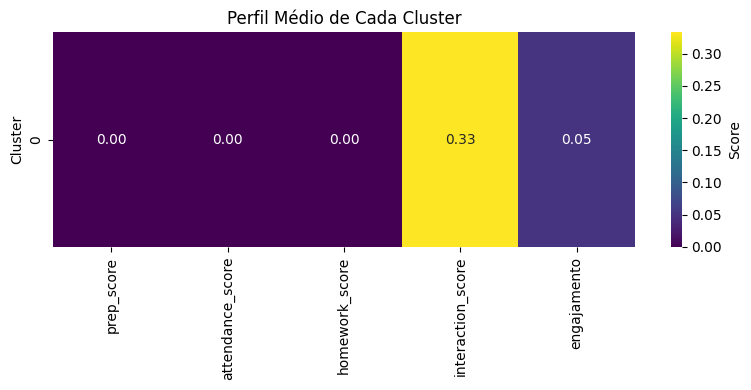

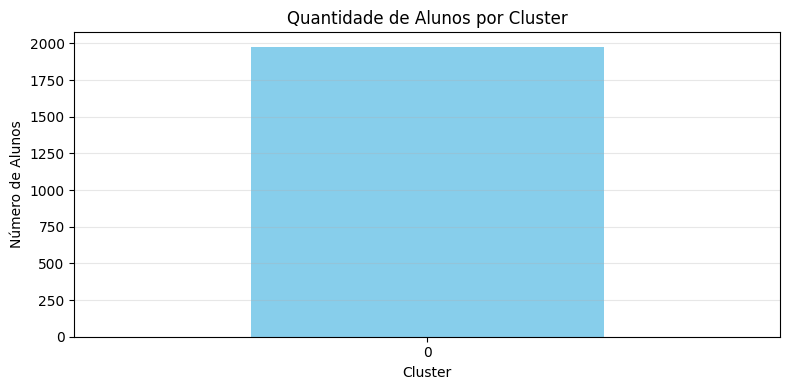

In [40]:
# Visualizar heatmap dos perfis de cluster
plt.figure(figsize=(8, 4))
sns.heatmap(cluster_profile, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Score'})
plt.title('Perfil Médio de Cada Cluster')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

# Visualizar distribuição de alunos por cluster
plt.figure(figsize=(8, 4))
aluno_stats['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Quantidade de Alunos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Alunos')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretação dos Clusters

### 🟥 Cluster 1 - ALTO RISCO CRÍTICO

- **Descrição**: Alunos praticamente desconectados (prep=0.00, attendance=0.09, homework=0.00)
- **Ação**: Contato imediato com aluno/responsável, conversa individual para entender causas das faltas
- **Risco**: Abandono iminente

### 🟧 Cluster 2 - Grupo Intermediário Baixo (Instáveis)

- **Descrição**: Medianos mas instáveis (prep=0.41, attendance=0.53, homework=0.35, interaction=0.63)
- **Ação**: Monitorar de perto, intervenções leves de motivação
- **Prognóstico**: Podem evoluir para Cluster 3 ou regredir para Cluster 1

### 🟨 Cluster 0 - Grupo Intermediário Alto

- **Descrição**: Relativamente bons mas não excepcionais (prep=0.47, attendance=0.59, homework=0.43)
- **Ação**: Fortalecer consistência, feedback positivo
- **Oportunidade**: Podem ser convertidos em super-engajados com pouco esforço

### 🟩 Cluster 3 - SUPER ENGAJADOS

- **Descrição**: Estáveis e comprometidos (prep=0.53, attendance=0.63, homework=0.48, interaction=0.71)
- **Ação**: Reforço positivo, desafios avançados
- **Função**: Termômetro de satisfação da turma, multiplicadores


In [41]:
# Resumo estatístico final
print("\n" + "="*60)
print("📊 RESUMO GERAL DO PIPELINE DE ANÁLISE")
print("="*60)

print(f"\n✓ Total de registros processados: {len(df_scores)}")
print(f"✓ Total de alunos únicos: {df_scores['Aluno'].nunique()}")
print(f"✓ Unidades: {', '.join(df_scores['Unidade'].unique())}")
print(f"✓ Salas: {', '.join(map(str, df_scores['Sala'].unique()))}")

print("\n📁 Arquivos gerados:")
print("  • eric-dados-compilados-LIMPO.csv - Dados limpos")
print("  • eric-dados-engajamento.csv - Dados com scores de engajamento")
print("  • clusters_alunos.csv - Clustering dos alunos")
print("  • perfil_clusters.csv - Perfis médios dos clusters")

print("\n✓ Pipeline completado com sucesso!")


📊 RESUMO GERAL DO PIPELINE DE ANÁLISE

✓ Total de registros processados: 25701
✓ Total de alunos únicos: 1977
✓ Unidades: Campinas, Capão Redondo, Diadema, Jabaquara, Mauá, Rio de Janeiro, Tatuapé, Unidade Virtual (aulas aos domingos), Unidade Virtual (aulas aos sábados), Vila Sônia (manhã), Vila Sônia (tarde)
✓ Salas: Four Corners A1, Four Corners B1, Four Corners B2, Four Corners B3, Four Corners C1, Four Corners C2, Four Corners D1, Four Corners D2, Four Corners E1, Four Corners F1, Four Corners G1, Four Corners G2, Four Corners H1, Four Corners H2, Four Corners I1, Four Corners I2, Four Corners J1, Four Corners J2, Four Corners A2, Four Corners F2, Four Corners A3, Four Corners E2, Four Corners G3, Four Corners H3, Four Corners I3, Four Corners J3

📁 Arquivos gerados:
  • eric-dados-compilados-LIMPO.csv - Dados limpos
  • eric-dados-engajamento.csv - Dados com scores de engajamento
  • clusters_alunos.csv - Clustering dos alunos
  • perfil_clusters.csv - Perfis médios dos clusters